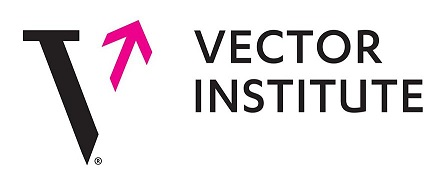
### **Welcome to the Bias in AI Course!**
This program is offered by Vector Institute in partnership with the CRA.

Instructor: Sayyed Nezhadi

Assignment Developer: Rishav Agarwal

Course Tutors: Reem Al-Saidi and Rishav Agarwal

Course Director: Melissa Valdez

### ***Never stop learning!***



### Assginment 4: Understanding bias in text recognition from images. 

This assignment is split in two parts. First we will create an end to end text recognition model, the same thing you see on your phone cameras. Then you'll try to break down the pipeline to understand sources of bias. The end to end system is based on a loose adaptation of the Apple text recognition framework. We will try to detect text in reciepts. 

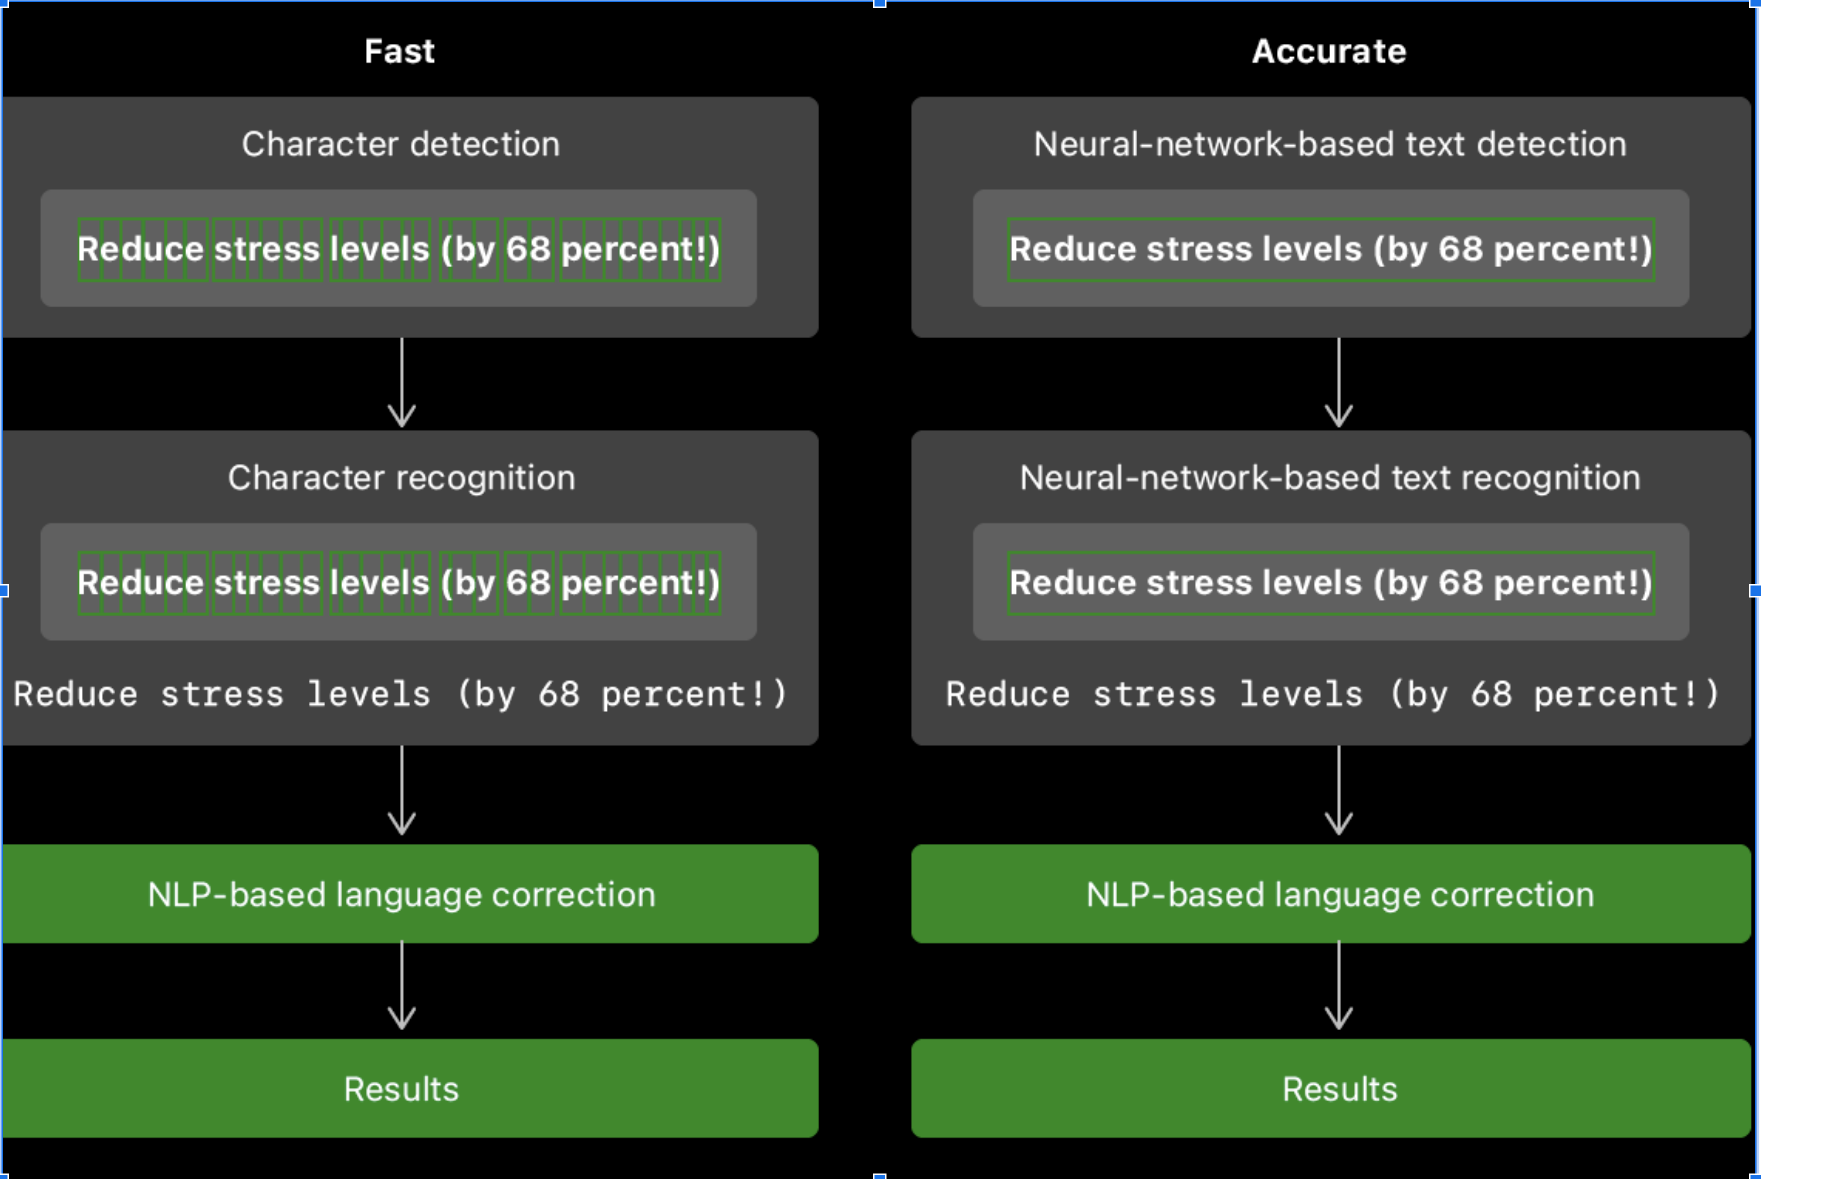

Source: https://developer.apple.com/documentation/vision/recognizing_text_in_images/

The character recognition pipeline is based on [Google Tesseract](https://tesseract-ocr.github.io/tessdoc/Home.html) and the neural network one is based on[TROCR](https://www.microsoft.com/en-us/research/publication/trocr-transformer-based-optical-character-recognition-with-pre-trained-models/).
The model libary  for TROCR we use is [Hugging face](https://huggingface.co).

The annotated images are taken from [ICDAR 2019 Robust Reading Challenge on Scanned Receipts OCR and Information Extraction](https://rrc.cvc.uab.es/?ch=2&com=introduction).

**Submission Note:** Convert to pdf and submit PDFs. Notebooks will not be graded.

**Grade:** This assigment is graded on a 80 point scale (+30 bonus available) but will contribute to 15% of your final grade. 

#### Changing Runtime

Change the runtime to use a GPU accelerator. You can use a free GPU on colab by selecting:

**Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

#### Installing Libraries

We will first install the relevant libraries. You must restart the instance (**Runtime** → **Restart Runtime**). Note that this needs to be done once.



In [1]:
!sudo apt install tesseract-ocr python-enchant 
!pip install pytesseract timm pyenchant transformers datasets  python-Levenshtein
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common enchant hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
  tesseract-ocr-eng tesseract-ocr-osd
Suggested packages:
  aspell-doc spellutils wordlist hunspell openoffice.org-hunspell
  | openoffice.org-core libenchant-voikko python-gobject python-gtk2
  python-wxgtk3.0
The following NEW packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common enchant hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
  python-enchant tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 14 newly installed, 0 to remove and 19 not upgraded.
Need to get 6,151 kB of archives.
Af

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-mnscw4be
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-mnscw4be
     |████████████████████████████████| 50 kB 6.0 MB/s 
     |████████████████████████████████| 79 kB 7.2 MB/s 
     |████████████████████████████████| 151 kB 77.6 MB/s 
     |████████████████████████████████| 1.4 MB 54.0 MB/s 
     |████████████████████████████████| 248 kB 68.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 96 kB 5.1 MB/s 
     |████████████████████████████████| 843 kB 65.0 MB/s 
     |████████████████████████████████| 117 kB 71.1 MB/s 
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux

#### Download the data

In [1]:
%mkdir  -p datasets
%cd datasets/
from IPython.display import clear_output
import zipfile
from pathlib import Path

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1YxvbdFAgQ_SalZ-aeSUzDI6PK2ITLsaX' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1YxvbdFAgQ_SalZ-aeSUzDI6PK2ITLsaX" -O SORIE_data.zip && rm -rf /tmp/cookies.txt
# Note that if you already have the data downloaded, this cell may ask you to replace the files or quit the process
!unzip -qq SORIE_data.zip
!rm -f SORIE_data.zip


/content/datasets
--2022-08-12 18:21:26--  https://docs.google.com/uc?export=download&confirm=t&id=1YxvbdFAgQ_SalZ-aeSUzDI6PK2ITLsaX
Resolving docs.google.com (docs.google.com)... 142.251.16.138, 142.251.16.101, 142.251.16.113, ...
Connecting to docs.google.com (docs.google.com)|142.251.16.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-4s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rq5qs7jc3svfkqclr2ejhnh333n9b4in/1660328475000/17454445809473129979/*/1YxvbdFAgQ_SalZ-aeSUzDI6PK2ITLsaX?e=download&uuid=805bf088-7c0b-4fe5-9fd0-e40db831bd65 [following]
--2022-08-12 18:21:26--  https://doc-10-4s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rq5qs7jc3svfkqclr2ejhnh333n9b4in/1660328475000/17454445809473129979/*/1YxvbdFAgQ_SalZ-aeSUzDI6PK2ITLsaX?e=download&uuid=805bf088-7c0b-4fe5-9fd0-e40db831bd65
Resolving doc-10-4s-docs.googleusercontent.com (doc-10-4s-docs.googleusercontent.com)..

#### Helper Functions

Here we will define some helper functions. You may change these if you need.


In [2]:
import cv2
import pytesseract 
from matplotlib import pyplot as plt
import numpy as np
import re
from PIL import Image
import torch 

def read_image(img_path, device):
  '''
  Given image path, read and returns the image in RGB format
  '''
  full_img = cv2.imread(img_path)
  full_img = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)
  if device == "cuda":
    full_img = torch.from_numpy(full_img).to(device)
  return full_img

def ocr_patch(img, lang = 'eng+fra'):
  '''
  lods the tesseract engine with given lang(str), passed the iamge through it and returns results
  '''
  results = pytesseract.image_to_data(img, lang=lang, output_type=pytesseract.Output.DICT)
  return results

def clean_str(s):
  '''
  given a string removes all special characters from it
  '''
  return re.sub(r"[^a-zA-Z0-9 ]", "", s.lower())



### Creating and Running the BlackBox

First we create the Blackbox. We will keep it simple and assume that we have perfect text locaization. The Blackbox will have three tuneable parameters:

1. image_configs: whether to augument the image
2. model_configs: which model to use simple or accurate
3. correction_config: whether to use basic spelling based text correction

In [3]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import enchant
from enchant.checker import SpellChecker
from Levenshtein import distance as lev_dist
import warnings
import torchvision

def metric(s1, s2, score_config):
  '''
  function that returns a metric between two strings
  score_config (dict)
    clean_type (str) lower or no_spl (remove special chars)
    type (str) lev for Levenshtein
  '''
  s1 = str(s1)
  s2 = str(s2)
  if score_config["clean_type"] == "lower":
    s1 = s1.lower()
    s2 = s2.lower()
  elif score_config["clean_type"] == "no_spl":
    s1 = clean_str(s1)
    s2 = clean_str(s2)
  if score_config["type"] == "lev":
    dist = lev_dist(s1, s2)
  return dist

class Blackbox():
  '''
  The blackbox class that instantiates and runs inference on given images
  The init takes three types of configs
    image configs:
      scale (float) scale factor
    model config
      type(str): trocr or tesseract
      lang(str): with tesseract we can pass in the language
    correction config
      flag (bool) whether to use the correction
      custom_list (list str) custom dict to use 
  '''
  def __init__(self, image_configs, model_configs, correction_config, device = "cuda"):
    self.image_configs = image_configs
    self.model_configs = model_configs
    self.correction_config = correction_config
    self.device = device

    if self.model_configs["type"] == "trocr":
      self.processor = TrOCRProcessor.from_pretrained(self.model_configs["model_pth"])
      self.model = VisionEncoderDecoderModel.from_pretrained( self.model_configs["model_pth"]).to(self.device)

  def spell_check(self, text, custom_list):
    chkr = SpellChecker("en_US", custom_list)
    chkr.set_text(text)
    for err in chkr:
        sug = err.suggest()[0]
        err.replace(sug)
    Spellchecked = chkr.get_text()
    return Spellchecked

  def __call__(self, image):

    if "scale" in self.image_configs:
      scale = self.image_configs["scale"]
      width, height  = image.shape[:2]
      if torch.is_tensor(image) and device == "cuda":
        image = torch.nn.functional.interpolate(image.permute(2,0,1), scale_factor=scale).permute(1,2,0)
      else:
        image = cv2.resize(image, dsize = (int(height*scale), int(width*scale)))

    if self.model_configs["type"] == "trocr":
      with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        pixel_values = self.processor(image, return_tensors="pt").pixel_values.to(self.device)
        generated_ids = self.model.generate(pixel_values)
        preds = self.processor.batch_decode(generated_ids, skip_special_tokens=True)[0] 
    
    if  self.model_configs["type"] == "tesseract":
      preds = ocr_patch(image, lang =  self.model_configs["lang"])
      preds = (" ").join(preds['text'])

    if self.correction_config["flag"]:
      preds =  self.spell_check(preds, self.correction_config["custom_list"] )

    return preds

#### Running the simple pipeline

Try running the simple pipeline and visualize the results.

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliabl

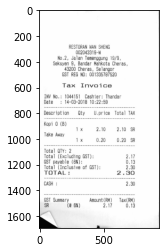

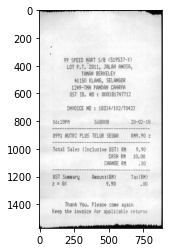

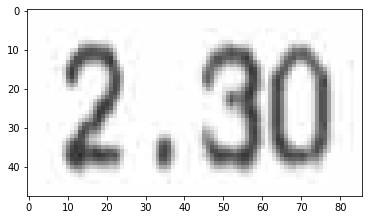

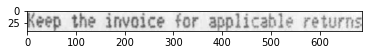

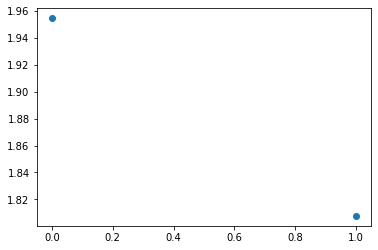

In [4]:
import glob
import tqdm

#getting list of images and annotations
images = glob.glob("/content/**/*.jpg", recursive = True)
annotations = [i[:-4]+".txt" for i in images]

device = "cpu" #use cuda for faster results 

#initializing the blackbox

blackbox = Blackbox(image_configs = {"scale": 1}, 
                    model_configs= {"type": "trocr",
                                    "model_pth": "microsoft/trocr-base-printed" }, 
                    correction_config = {"flag": True, "custom_list": ["en_US"]},
                    device = device)

score_config = {"type": "lev","clean_type" : "lower"} 

image_limt = 2 # change this as you like

all_metrics = {}

for img_pth, ann_pth in tqdm.tqdm(zip(images[:image_limt], annotations[:image_limt])):
  img = read_image(img_pth, device = "cpu")
  with open(ann_pth) as f:
    ann = f.readlines()  
  img_metric = 0
  max_so_far = -np.inf
  bbox = [int(i) for i in ann[0].split(",")[:8]]

  # assuming we have perfect localization, we can use the ground truth boxes
  for a in ann:
    crop = [int(i) for i in a.split(",")[:8]]
    gt_text = (",").join(a.split(",")[8:])
    img_crop = img[crop[1]:crop[-1], crop[0]:crop[2], :]
    generated_text = blackbox(img_crop)
    m = metric(generated_text, gt_text, score_config)
    if m > max_so_far:
      bbox = crop
    img_metric += m
  all_metrics[img_pth] = [img_metric/len(ann), bbox]

all_metrics = sorted(all_metrics.items(), key=lambda x:x[1], reverse = True)

# visualizing the worst performing images
for img, _ in all_metrics:
  img = cv2.imread(img)
  plt.imshow(img)
  plt.show()

# visualizing the worst predicted string in the worst performing images
for img, b in all_metrics:
  crop = b[1]
  img = cv2.imread(img)
  img_crop = img[crop[1]:crop[-1], crop[0]:crop[2], :]
  plt.imshow(img_crop)
  plt.show()

# scatter plot of scores
scores = []
for img, b in all_metrics:
  scores.append(b[0])
plt.scatter( list(range(len(scores))), scores)
plt.show()

#### Running the Neural Network Based *Pipeline*

Try running the simple pipeline and visualize the results.


2it [00:14,  7.34s/it]


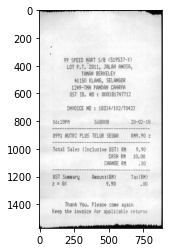

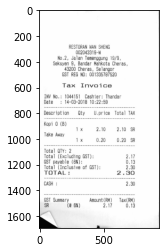

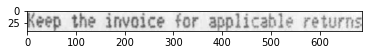

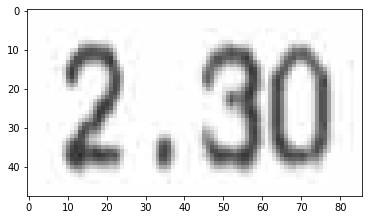

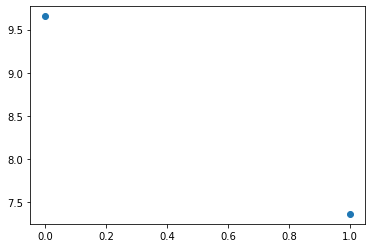

In [5]:
import glob
import tqdm

#getting list of images and annotations
images = glob.glob("/content/**/*.jpg", recursive = True)
annotations = [i[:-4]+".txt" for i in images]

device = "cuda" #use cuda for faster results 

#initializing the blackbox

blackbox = Blackbox(image_configs = {"scale": 1}, 
                    model_configs= {"type": "tesseract",
                                    "lang" : "eng"}, 
                    correction_config = {"flag": True, "custom_list": ["en_US"]},
                    device = device)

score_config = {"type": "lev","clean_type" : "lower"} 

image_limt = 2 # change this as you like

all_metrics = {}

for img_pth, ann_pth in tqdm.tqdm(zip(images[:image_limt], annotations[:image_limt])):
  img = read_image(img_pth, device = "cpu")
  with open(ann_pth) as f:
    ann = f.readlines()  
  img_metric = 0
  max_so_far = -np.inf
  bbox = [int(i) for i in ann[0].split(",")[:8]]

  # assuming we have perfect localization, we can use the ground truth boxes
  for a in ann:
    crop = [int(i) for i in a.split(",")[:8]]
    gt_text = (",").join(a.split(",")[8:])
    img_crop = img[crop[1]:crop[-1], crop[0]:crop[2], :]
    generated_text = blackbox(img_crop)
    m = metric(generated_text, gt_text, score_config)
    if m > max_so_far:
      bbox = crop
    img_metric += m
  all_metrics[img_pth] = [img_metric/len(ann), bbox]

all_metrics = sorted(all_metrics.items(), key=lambda x:x[1], reverse = True)

# visualizing the worst performing images
for img, _ in all_metrics:
  img = cv2.imread(img)
  plt.imshow(img)
  plt.show()

# visualizing the worst predicted string in the worst performing images
for img, b in all_metrics:
  crop = b[1]
  img = cv2.imread(img)
  img_crop = img[crop[1]:crop[-1], crop[0]:crop[2], :]
  plt.imshow(img_crop)
  plt.show()

# scatter plot of scores
scores = []
for img, b in all_metrics:
  scores.append(b[0])
plt.scatter( list(range(len(scores))), scores)
plt.show()

#### Part 1: Compare and contrast the two [20]

How does the tesseract engine compare to the neural network engine? What are the similarities in results and what are the differences? 

Answer:

neural network ran very slow. same text recognition for two worse quality images but scatter plot scores for metrics

#### Part 2: Identifying and Eliminating bias [15 x 4 = 60]
 
Analyse each of the following independently given the downstream task in mind. Ideally you should run some experiments by simply copy-pasting the configs from one of the cells above, but qualitative answers with rationale are acceptable. Choosing not to run code experiements would reduce your score on this question by 30%.
 
1. **Image configs:** Does changing the image properties help? Why could this be? [*Hint: TROCR does some image processing under the hood.*] 
2. **Model configs:** Let's assume we use the TROCR model. Try switching models by changing the model path from the [repository](https://huggingface.co/models?search=microsoft/trocr). Does a model trained on [handwritten data]('microsoft/trocr-base-handwritten') perform better than a printed one? If so, why? Think with respect to the downstream task. Is there a data bias?
3. **Correction configs:** Does correction based on the English language help? what are the typically missed predictions? How can we identify and reduce them?
4. **Can the way we evaluate miss some instances of bias?** Is the evaluation method fair? What metrics would you use for the task at hand. [*Hint: Look at the task [description](https://rrc.cvc.uab.es/?ch=13&com=tasks)*]

Answer 2.1: Analysing changes changing image scale 

In [10]:
def analyse_changes(image_scale = 1, model_type = "tesseract", model_lang = "eng", correction_flag = True, correction_list = ["en_US"]):

  #getting list of images and annotations
  images = glob.glob("/content/**/*.jpg", recursive = True)
  annotations = [i[:-4]+".txt" for i in images]

  device = "cuda" #use cuda for faster results 

  #initializing the blackbox

  blackbox = Blackbox(image_configs = {"scale": image_scale}, 
                      model_configs= {"type": model_type,
                                      "lang" : model_lang}, 
                      correction_config = {"flag": correction_flag, "custom_list": correction_list},
                      device = device)

  score_config = {"type": "lev","clean_type" : "lower"} 

  image_limt = 3 # change this as you like

  all_metrics = {}

  for img_pth, ann_pth in tqdm.tqdm(zip(images[:image_limt], annotations[:image_limt])):
    img = read_image(img_pth, device = "cpu")
    with open(ann_pth) as f:
      ann = f.readlines()  
    img_metric = 0
    max_so_far = -np.inf
    bbox = [int(i) for i in ann[0].split(",")[:8]]

    # assuming we have perfect localization, we can use the ground truth boxes
    for a in ann:
      crop = [int(i) for i in a.split(",")[:8]]
      gt_text = (",").join(a.split(",")[8:])
      img_crop = img[crop[1]:crop[-1], crop[0]:crop[2], :]
      generated_text = blackbox(img_crop)
      m = metric(generated_text, gt_text, score_config)
      if m > max_so_far:
        bbox = crop
      img_metric += m
    all_metrics[img_pth] = [img_metric/len(ann), bbox]

  all_metrics = sorted(all_metrics.items(), key=lambda x:x[1], reverse = True)

  # visualizing the worst performing images
  for img, _ in all_metrics:
    img = cv2.imread(img)
    plt.imshow(img)
    plt.show()

  # visualizing the worst predicted string in the worst performing images
  for img, b in all_metrics:
    crop = b[1]
    img = cv2.imread(img)
    img_crop = img[crop[1]:crop[-1], crop[0]:crop[2], :]
    plt.imshow(img_crop)
    plt.show()

  # scatter plot of scores
  scores = []
  for img, b in all_metrics:
    scores.append(b[0])
  plt.scatter( list(range(len(scores))), scores)
  plt.show()



3it [00:21,  7.31s/it]


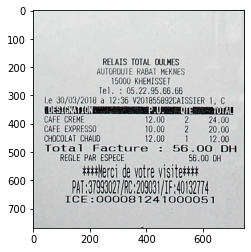

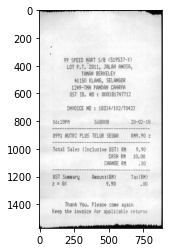

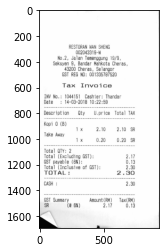

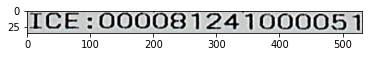

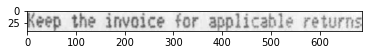

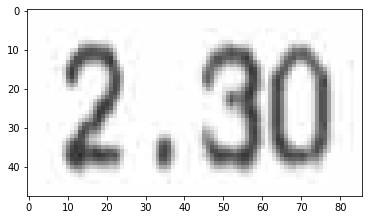

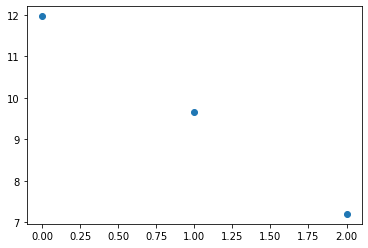

In [11]:
# Changes in image configs in neural pipeline: scale = 2

analyse_changes(2)

Results below for `scale = 5`

3it [00:28,  9.58s/it]


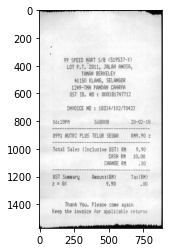

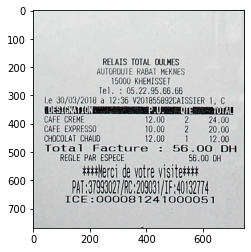

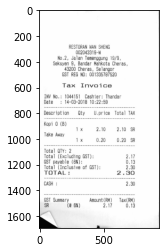

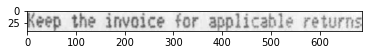

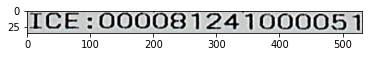

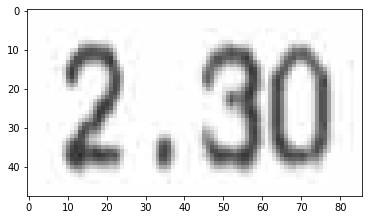

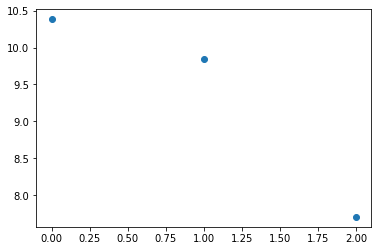

In [12]:
analyse_changes(5)

For `scale` = 10 

3it [00:58, 19.42s/it]


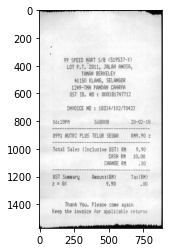

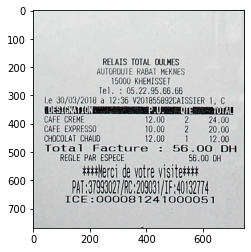

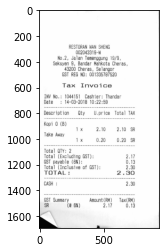

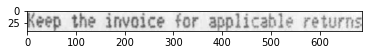

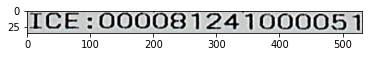

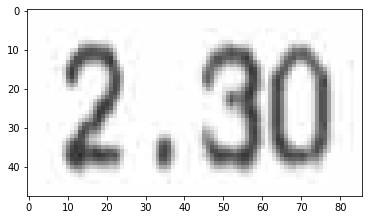

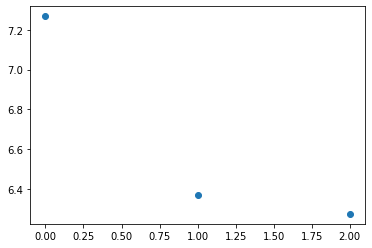

In [13]:
analyse_changes(10)

With higher `scale`, the confidence scores of text recognition decreased. More zoom in is likely to jeopardize the character recognition.

Answer 2.2 Analysing changes changing model configs for TROCR model

In [25]:
import glob
import tqdm

def analyse_trocr_changes(model_path = "microsoft/trocr-base-printed", flag = True):
  #getting list of images and annotations
  images = glob.glob("/content/**/*.jpg", recursive = True)
  annotations = [i[:-4]+".txt" for i in images]

  device = "cpu" #use cuda for faster results 

  #initializing the blackbox

  blackbox = Blackbox(image_configs = {"scale": 1}, 
                      model_configs= {"type": "trocr",
                                      "model_pth": model_path}, 
                      correction_config = {"flag": True, "custom_list": ["en_US"]},
                      device = device)

  score_config = {"type": "lev","clean_type" : "lower"} 

  image_limt = 3 # change this as you like

  all_metrics = {}

  for img_pth, ann_pth in tqdm.tqdm(zip(images[:image_limt], annotations[:image_limt])):
    img = read_image(img_pth, device = "cpu")
    with open(ann_pth) as f:
      ann = f.readlines()  
    img_metric = 0
    max_so_far = -np.inf
    bbox = [int(i) for i in ann[0].split(",")[:8]]

    # assuming we have perfect localization, we can use the ground truth boxes
    for a in ann:
      crop = [int(i) for i in a.split(",")[:8]]
      gt_text = (",").join(a.split(",")[8:])
      img_crop = img[crop[1]:crop[-1], crop[0]:crop[2], :]
      generated_text = blackbox(img_crop)
      m = metric(generated_text, gt_text, score_config)
      if m > max_so_far:
        bbox = crop
      img_metric += m
    all_metrics[img_pth] = [img_metric/len(ann), bbox]

  all_metrics = sorted(all_metrics.items(), key=lambda x:x[1], reverse = True)

  # visualizing the worst performing images
  for img, _ in all_metrics:
    img = cv2.imread(img)
    plt.imshow(img)
    plt.show()

  # visualizing the worst predicted string in the worst performing images
  for img, b in all_metrics:
    crop = b[1]
    img = cv2.imread(img)
    img_crop = img[crop[1]:crop[-1], crop[0]:crop[2], :]
    plt.imshow(img_crop)
    plt.show()

  # scatter plot of scores
  scores = []
  for img, b in all_metrics:
    scores.append(b[0])
  plt.scatter( list(range(len(scores))), scores)
  plt.show()

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliab

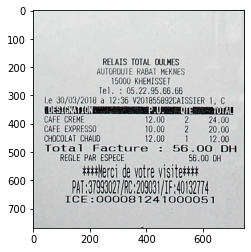

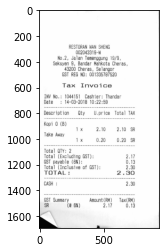

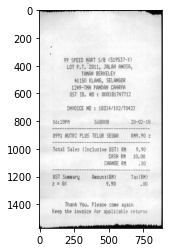

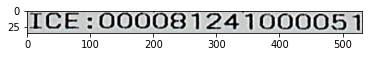

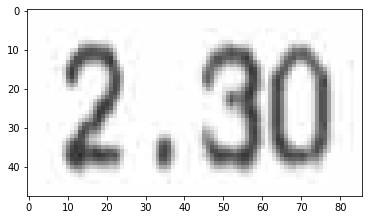

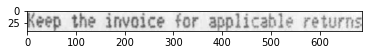

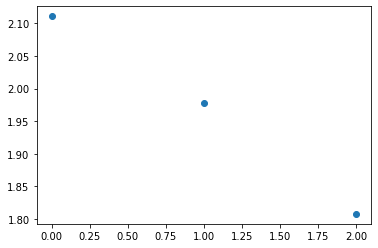

In [19]:
#comparing TROCR's performance for printed v/s. handwritten text.

analyse_trocr_changes("microsoft/trocr-large-printed")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain re

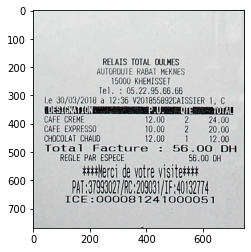

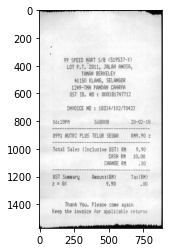

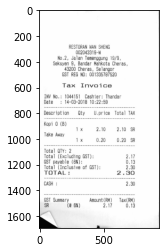

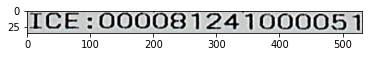

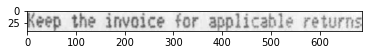

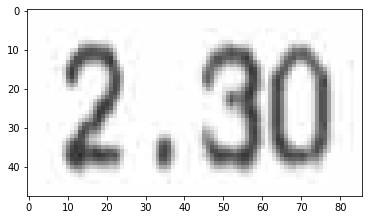

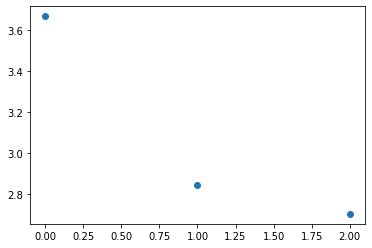

In [20]:
analyse_trocr_changes("microsoft/trocr-large-handwritten")

Answer 2.c:

3it [00:31, 10.34s/it]


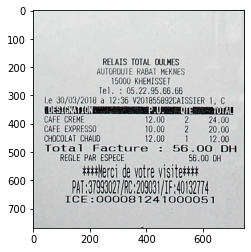

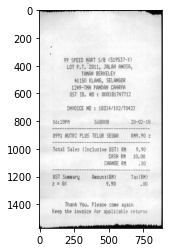

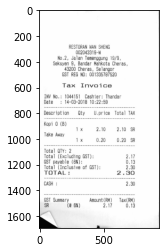

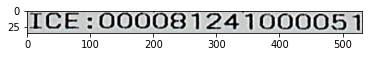

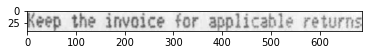

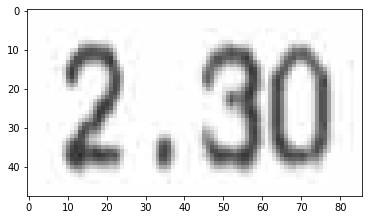

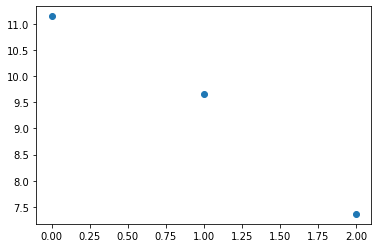

In [21]:
# Results with corrections using tesseract model
analyse_changes(image_scale = 1, model_type = "tesseract", model_lang = "eng", correction_flag = True, correction_list = ["en_US"])

3it [00:27,  9.21s/it]


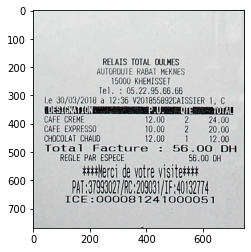

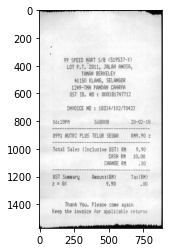

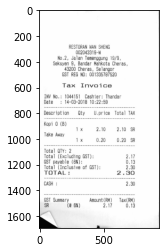

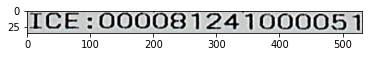

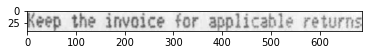

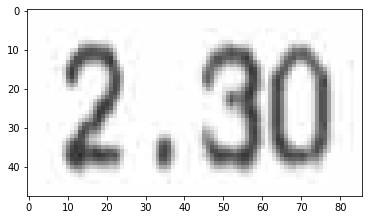

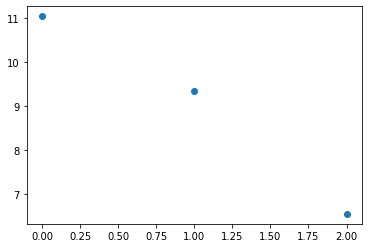

In [22]:
# Results without corrections using tesseract model
analyse_changes(correction_flag = False)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliab

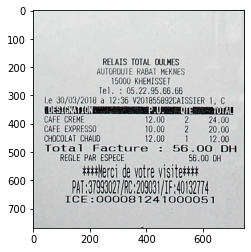

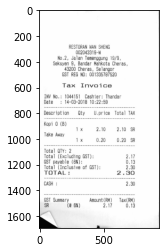

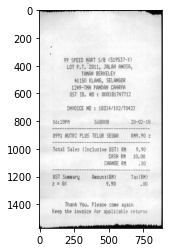

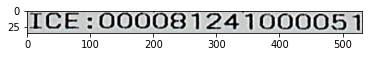

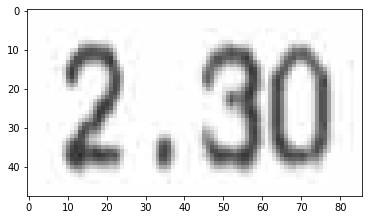

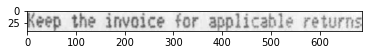

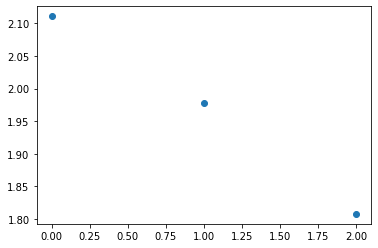

In [26]:
# Results without corrections using TROCR
analyse_trocr_changes(model_path = "microsoft/trocr-large-printed", flag = False)

Answer 2.4